<a href="https://colab.research.google.com/github/HopeRetina/image_related/blob/main/Costes_Randomization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/data_collection/

/content/drive/MyDrive/data_collection


In [ ]:
# Load images
Ca = Image.open('KO1_C1_frame10_Cav.tif')
rib = Image.open('KO1_C3_frame10_ribeye.tif')

In [ ]:
# Convert into numpy arrays

ca = np.array(Ca)
rib = np.array(rib)

print(type(ca))
print('\n')
print(type(rib))

<class 'numpy.ndarray'>


<class 'numpy.ndarray'>


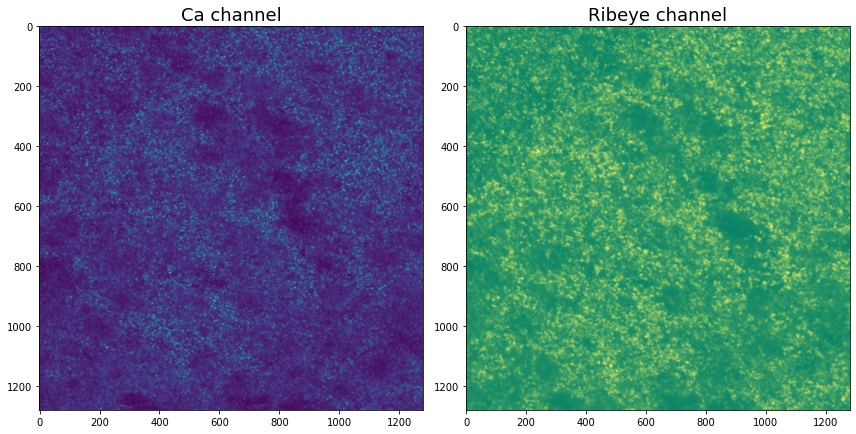

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(ca)
ax1.set_title('Ca channel', size=18)
ax2.imshow(rib, cmap='summer')
ax2.set_title('Ribeye channel', size=18)

plt.show()


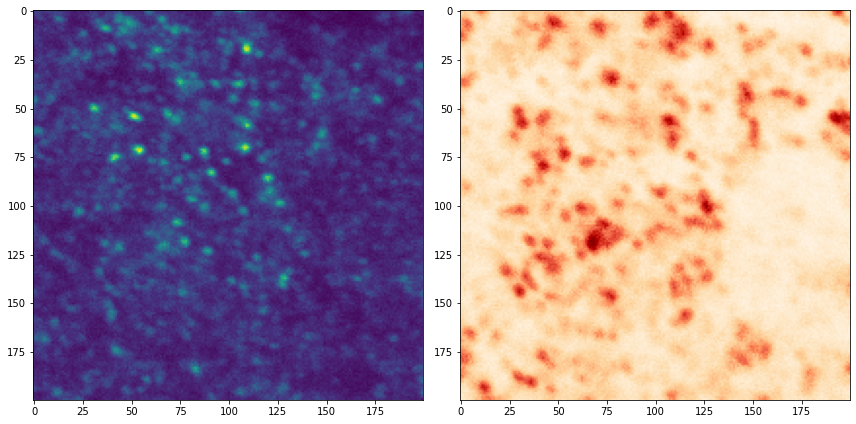

In [ ]:
# Extract a small sample (100 x 100) from it, there's not enough ramp for corrcoef calculation on the whole image

ca_samp = ca[800:1000, 800:1000]
rib_samp = rib[800:1000, 800:1000]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(ca_samp)
ax2.imshow(rib_samp, cmap='OrRd')

In [ ]:
# Check whether we got the shape right
ca_samp.shape == rib_samp.shape

True

In [ ]:
# A quick check on PCC

vec_len = ca_samp.shape[0]*ca_samp.shape[-1]

x = ca_samp.reshape(vec_len)
y = rib_samp.reshape(vec_len)

r = np.corrcoef(x, y)

r

array([[1.        , 0.47508835],
       [0.47508835, 1.        ]])

In [ ]:
pcc = r[0][-1]
pcc

0.47508835223152507

In [ ]:
vec_len

40000

#Now reshape, split image into tiles

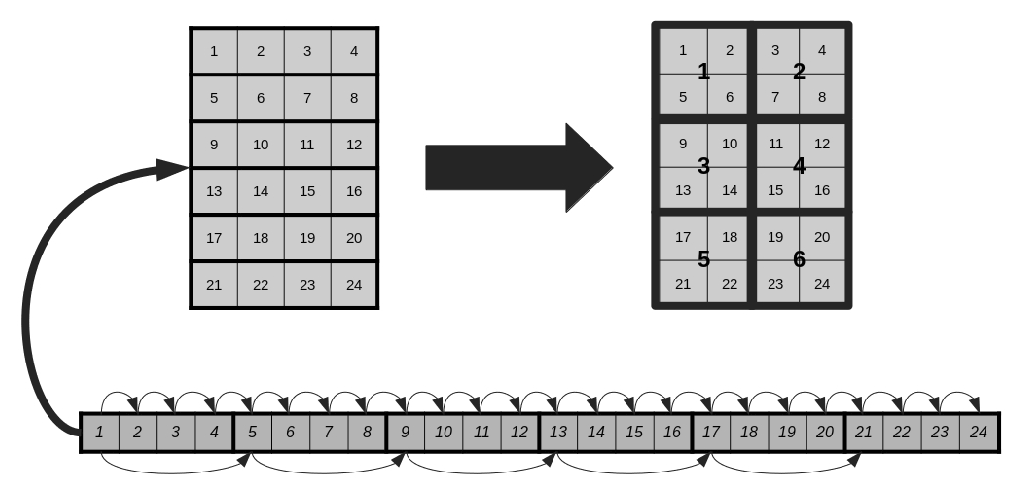

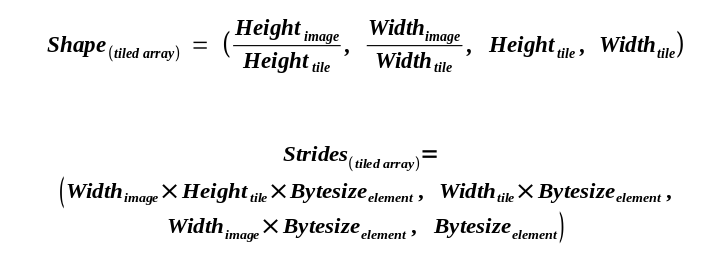

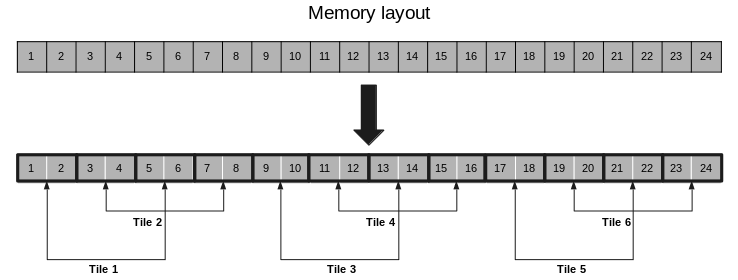

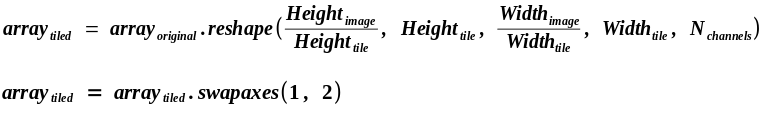

In [ ]:
ca_samp.shape

(100, 100)

In [ ]:
byte_size = ca_samp.strides[-1]

byte_size

1

#I'll try 10 x 10 pixels per tile, so for a 100 x 100 image, 10 tiles per row and per column.


---



In [ ]:
img_row = ca_samp.shape[0]
img_col = ca_samp.shape[-1]


# Try 50 x 50, 4 tiles
row_per_tile = 8
col_per_tile = 8

tile_shape = (int(img_row/row_per_tile), int(img_col/col_per_tile), row_per_tile, col_per_tile)

# Swap axes (1 and 2), for our purpose
tile_shape = (tile_shape[0], tile_shape[2], tile_shape[1], tile_shape[3])

tile_strides = (img_col*row_per_tile*byte_size, 
                col_per_tile*byte_size,
                img_col*byte_size,
                byte_size)

In [ ]:
tile_shape

(25, 8, 25, 8)

In [ ]:
tile_strides

(1600, 8, 200, 1)

In [ ]:
# Reshape

tiles = ca_samp.reshape(tile_shape)
tiles = tiles.swapaxes(1, 2)

In [ ]:
tiles.shape

(25, 25, 8, 8)

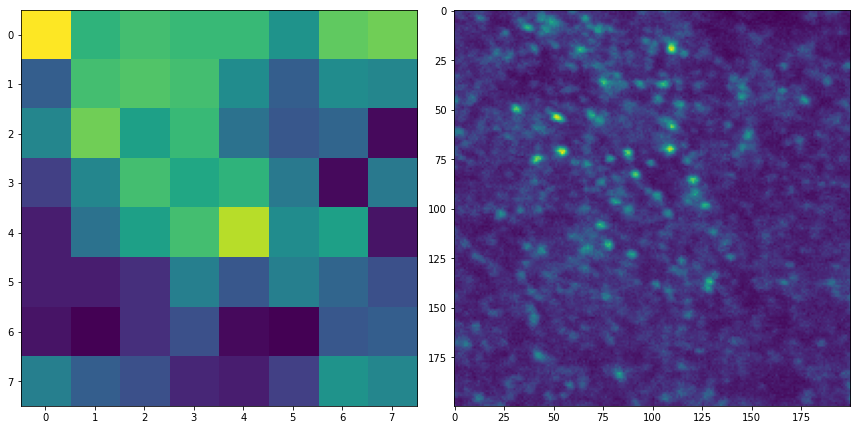

In [ ]:

# Take a look at the first tile, side-by-side with the original image

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(tiles[0][0])
ax2.imshow(ca_samp)

In [ ]:
# Now flatten it

flat_tiles = tiles.reshape(tiles.shape[0]*tiles.shape[1], row_per_tile, col_per_tile)

flat_tiles.shape

(625, 8, 8)

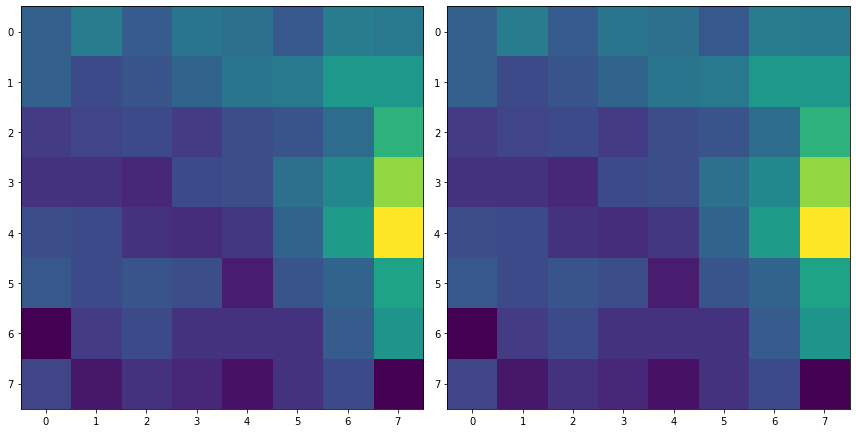

In [ ]:
# Check the last tile of the two reshaped images, they should look the same

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(tiles[-1][-1])
ax2.imshow(flat_tiles[-1, :, :])

#Now shuffle multiple times.

In [ ]:
# Try shuffle once first

shuffled_flat = np.random.permutation(flat_tiles)

In [ ]:
# Reshape back
reshaped_shuffled = shuffled_flat.reshape(tiles.shape[0], tiles.shape[1], row_per_tile, col_per_tile)

In [ ]:
pixel_ca = ca_samp.reshape(vec_len)
pixel_shuffle = np.random.permutation(pixel_ca)
pixel_shuffle = pixel_shuffle.reshape(200, 200)

pixel_shuffle.shape

(200, 200)

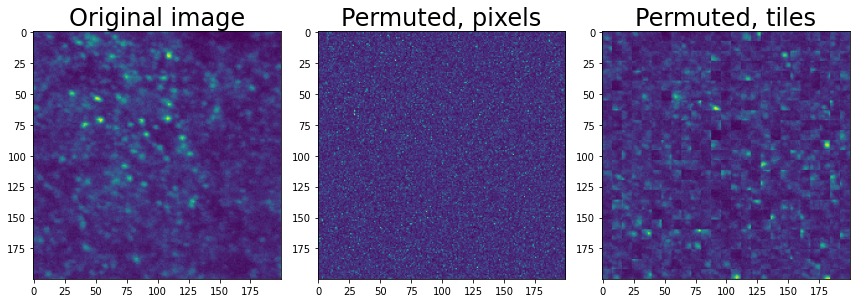

In [ ]:
# # Swap axes first, then reshape
reshape_shuffle_swap_axes  = reshaped_shuffled.swapaxes(1, 2)

stitch_back = reshape_shuffle_swap_axes.reshape(img_col, img_row)

# Now shuffle individual pixels
pixel_ca = ca_samp.reshape(vec_len)
pixel_shuffle = np.random.permutation(pixel_ca)
pixel_shuffle = pixel_shuffle.reshape(200, 200)


# Plot them side-by-side
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(ca_samp)
ax1.set_title('Original image', size=24)
ax2.imshow(pixel_shuffle)
ax2.set_title('Permuted, pixels', size=24)
ax3.imshow(stitch_back)
ax3.set_title('Permuted, tiles', size=24)

plt.savefig('Permutation_illustration_KO.png', bbox_inches = 'tight', dpi=900)
plt.show()

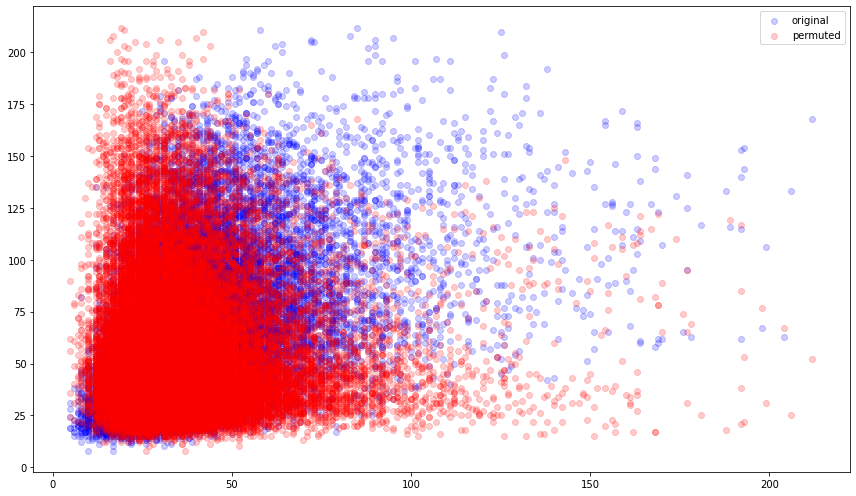

In [ ]:
# Scatter plot
plt.scatter(ca_samp, rib_samp, alpha=0.2, color='b', label='original')
plt.scatter(stitch_back, rib_samp, alpha=0.2, color='r', label='permuted')
plt.legend()
plt.show()

#Not a good idea to use linear regression for detecting thresholds for Mander's coefficients.

In [ ]:
# Calculate PCC again
new = stitch_back.reshape(vec_len)
ca_ori = ca_samp.reshape(vec_len)
rib_ori = rib_samp.reshape(vec_len)

PCC_new = np.corrcoef(new, rib_ori)

PCC_original = np.corrcoef(ca_ori, rib_ori)

print('PCC of original image: ' + str(PCC_original[0][-1]))
print('\n')
print('PCC of shuffled image: ' + str(PCC_new[0][-1]))

PCC of original image: 0.47508835223152507


PCC of shuffled image: -0.00782534209695104


In [ ]:
# Now do it multiple times

num_shuffle = 5000
PCC_permutation = np.zeros(num_shuffle)

for i in range(num_shuffle):
  tmp = np.random.permutation(flat_tiles) # shuffle
  reshaped_tmp = tmp.reshape(tiles.shape[0], tiles.shape[1], row_per_tile, col_per_tile) # reshape
  reshape_tmp_swap_axes  = reshaped_tmp.swapaxes(1, 2) # swap axes
  stitch_back = reshape_tmp_swap_axes.reshape(img_col, img_row) # reshape again
  flat_stitch_back = stitch_back.reshape(vec_len)
  pcc = np.corrcoef(flat_stitch_back, rib_ori)
  PCC_permutation[i] = pcc[0][-1]


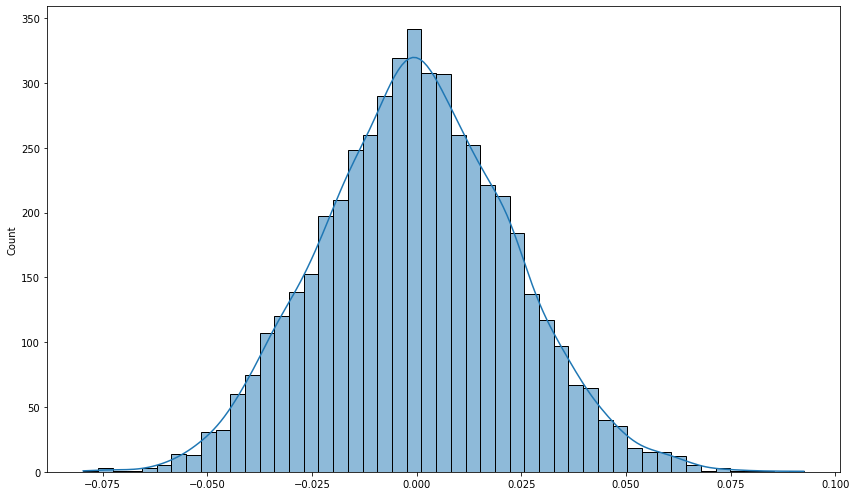

In [ ]:
sns.histplot(data=PCC_permutation, kde=True)

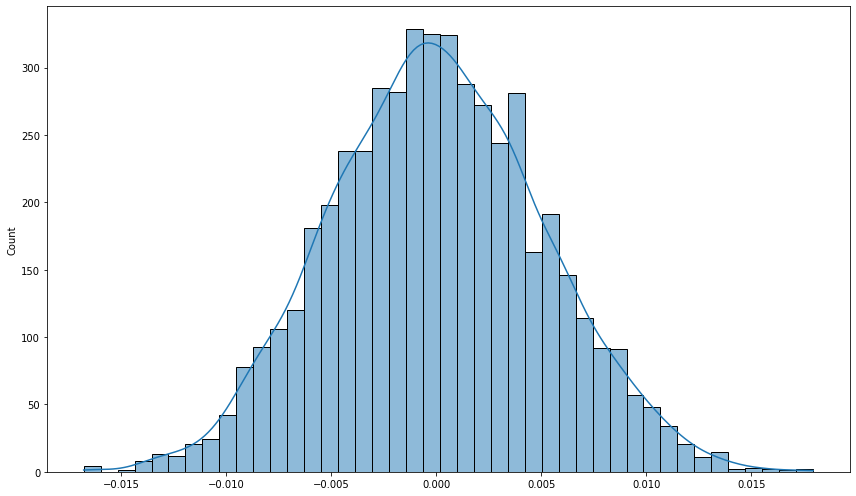

In [ ]:
# Now do the shuffling multiple times, let's say 100 times

flat_ca = ca_samp.reshape(vec_len)
r_prob_pixel = np.zeros(num_shuffle) # Allocate

for i in range(num_shuffle):
  tmp = np.random.permutation(flat_ca)
  r_prob_pixel[i] = np.corrcoef(tmp, rib_ori)[0][-1]

sns.histplot(data=r_prob_pixel, kde=True)

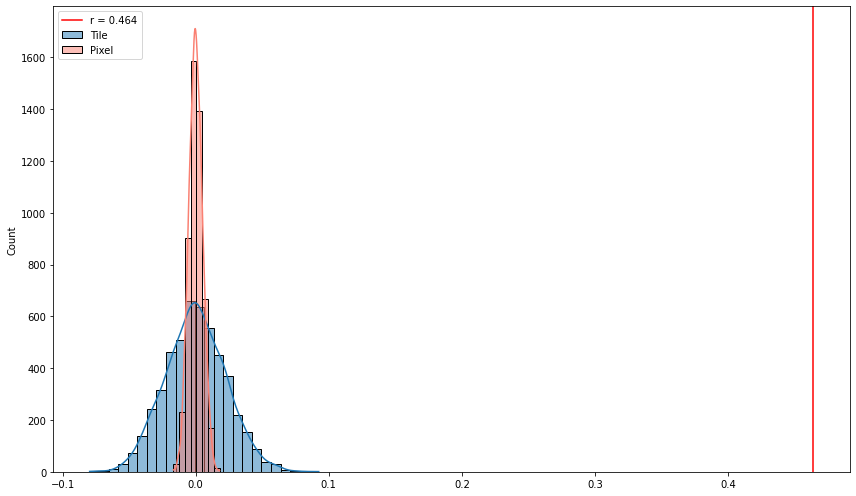

In [ ]:
plt.rcParams["figure.figsize"] = [12, 7]

sns.histplot(data=PCC_permutation, bins=24, kde=True, label='Tile')
sns.histplot(data=r_prob_pixel, bins=8, color='salmon', kde=True, label='Pixel')
plt.axvline(0.464, 0, 3000, color='r', label='r = 0.464')
plt.legend()
plt.savefig('PCC_distribution_KO8x8.png', bbox_inches = 'tight', dpi=900)

#Import PCC csv data

In [ ]:
# merging two wt files
wt = pd.concat(
    map(pd.read_csv, ['WT1_coeff_Results_terminal.csv', 'WT2_coeff_Results_terminal.csv']), ignore_index=True)

wt.head

In [ ]:
# Calculate average PCC of WT

In [ ]:
ko = pd.concat(
    map(pd.read_csv, ['KO1_coeff_Results_terminal.csv', 'KO2_coeff_Results_terminal.csv', 'KO3_coeff_Results_terminal.csv']), 
    ignore_index=True)

ko.head()

In [ ]:
# Calculate average PCC of KO